# Lap Efficiency Correlation Report

Date: November 21, 2024

Authors: Tamzeed Quazi, Jonah Lee

## Overview

Following our participation in the Formula Sun Grand Prix in July 2024, we present an analysis the factors correlating to our efficiency throughout the race.

### Motivation

See Lap [Efficiency Correlation DR0](https://docs.google.com/document/d/1tNlw1JpEPYcANT86QSTXvcIzSa9q5ro3QSOf27_WUEo/edit?tab=t.0).

- Quantitatively investigate which factors affect efficiency at FSGP using:
    - Telemetry data
    - Timing spreadsheet records
    - Weather data
- Purpose: understanding efficiency can help us optimize performance by operating as close as possible to our most efficient conditions


### Vocabulary

- Lap Energy
    - The net number of Joules (J) of electrical energy consumed by the motor (accounting for regen) between the lap start and end time recorded in our FSGP Timing Spreadsheet.
- Practical Efficiency
    - The energy per unit distance (J/m) computed as Lap Energy / 5070m, where 5070m is the given length of the NCM Motorsports Park track.
- Real Efficiency
    - The energy per unit distance (J/m) computed as Lap Energy / Distance Travelled where Distance Travelled is obtained as an integral of speed over the lap.
 
Why motor energy? - LVS & Array Power are largely independent of driving behaviour, so they not relevant to our optimization of speed & driving style.




## Imports

In [84]:
from data_tools.query import DBClient
import datetime
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Open Meteo API
import openmeteo_requests
import requests_cache
from retry_requests import retry

FSGP_TRACK_LEN_M = 5_070

driver_colours = {
    "Alex": "red",
    "Bryan": "orange",
    "Diego": "green",
    "Phoebe": "blue"
}

data_client = DBClient("can_log_prod")

Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


## Load Data

See `correlation_df.py` for querying and derivation of data. Since this querying requires a connection to our UBC Solar Tailnet and takes a few minutes, we have stored our derived data for this analysis in a `lap_data.csv`.

In [44]:
df = pd.read_csv("./lap_data.csv")
df.head(10)

,lap_distance_(m),energy_total_(J),energy_regen_(J),speed_variance_(mph^2),motor_power_variance_(W^2),motor_current_variance_(A^2),acceleration_variance_(m^2/s^4),accelerator_variance,acceleration_avg_(m/s^2),battery_temp_avg_(C),pack_current_avg_(A),lap_index,lap_number,lap_end_time,day,driver,speed_avg_(mph),efficiency_practical_(J/m),efficiency_real_(J/m)
0,5422.621217619539,845440.7592498517,19444.581794553666,10.70694366541461,4299372.535592417,285.1222100417652,0.0036770449582751,1330.3649889790645,0.0020392141820353,29.81666393250792,15.096573856728556,0,1,2024-07-16 15:07:04+00:00,1,Diego,26.745,166.75360142995103,155.9099788314164
1,5110.3660202388,742762.6773114646,24433.210032340416,2.6990476183683114,4754985.389726375,318.2146439617965,0.0032276091619134,1492.9359629289386,-0.00013029928462,30.66600450178685,15.10701511983404,1,2,2024-07-16 15:13:09+00:00,1,Diego,31.068,146.5015142626163,145.3443206161496
2,5090.330927985945,622935.3576563572,8203.242310369418,1.1828161230215108,1788748.696184072,118.54428720581876,0.0017574678779565,575.6078136218408,-0.0001274787381783,31.0,10.042580000596228,2,3,2024-07-16 15:20:19+00:00,1,Diego,26.372,122.86693444898565,122.37620038248272
3,5171.397775814052,628939.8490316086,5167.430689083902,1.897054651411404,2097404.6645799447,140.48855593312013,0.0021367664045727,706.120444204757,0.0001030009284657,31.61864392535724,10.421669946462266,3,4,2024-07-16 15:27:21+00:00,1,Diego,26.872,124.051252274479,121.61892708642094
4,5116.421189229325,632982.2708804868,1826.344625235744,1.927264033563438,2787216.020188109,189.24553497508387,0.0021595044802341,893.5734615149352,-0.0002755629287228,32.0,10.687179977286124,4,5,2024-07-16 15:33:59+00:00,1,Diego,28.492,124.84857413816307,123.71582547054368
5,5147.460343315915,650760.3479438522,2754.9002805427617,1.7526588702087336,2993137.086520944,205.29670427715672,0.0023118797050197,942.051719716663,3.802070690853493e-05,32.21109133825223,11.190643958392863,5,6,2024-07-16 15:40:21+00:00,1,Diego,29.686,128.35509821377755,126.42357678167994
6,5269.859661132362,665763.3515050309,2868.443348560109,9.73353496317702,2921007.692465615,200.93325001921963,0.0022854344413118,981.2398394719402,-7.783578198220222e-05,33.0,9.809869768138594,6,7,2024-07-16 15:47:45+00:00,1,Diego,25.541,131.3142705138128,126.3341709866283
7,5151.753049545288,650773.6780310014,6558.633813307358,1.5877723968985706,2751866.8650973705,191.8643217129577,0.0023836313074267,890.992443758054,6.270254096961112e-05,32.498827948223926,11.374014286502986,7,8,2024-07-16 15:54:10+00:00,1,Diego,29.455,128.35772742228824,126.32082162564856
8,5106.23311301851,627637.1251017407,8121.477653482564,1.341076153409468,2897804.2349360534,205.41875095603243,0.0023573396019313,969.8747646775992,-8.118107146820903e-05,32.0,11.014714646680018,8,9,2024-07-16 16:00:39+00:00,1,Diego,29.152,123.79430475379502,122.91587775371224
9,5152.105992597277,668908.1440541805,8188.121412481056,1.2246257025176737,3412304.448321949,246.43155256027887,0.0028051368819056,1195.6621383047614,0.0001488175635279,32.0,12.1173889724169,9,10,2024-07-16 16:07:05+00:00,1,Diego,29.378,131.9345451783393,129.8319842439753


In [45]:
distance_filter = np.logical_and(df["lap_distance_(m)"] > 5000, df["lap_distance_(m)"] < 5200)
filtered_df = df[distance_filter]

## Results

The below function simplifies plotting correlation. We then analyze several factors that we believe may have a correlation with lap energy

In [46]:
def plot_relationship(df, feature_col, target_col='energy_total_(J)', poly_degree=2, color_by_driver=False, show_fit=True):
    """
    Plot the relationship between a feature and the target variable.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    feature_col (str): Name of the feature column
    target_col (str): Name of the target column
    poly_degree (int): Degree of polynomial fit (default: 2)
    color_by_driver (bool): If True, points will be colored by driver (default: False)
    show_fit (bool): If True, shows polynomial fit line (default: True)
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    
    plt.figure(figsize=(12, 6))
    
    # Convert datetime to numbers for plotting if necessary
    if pd.api.types.is_datetime64_any_dtype(df[feature_col]):
        x = mdates.date2num(df[feature_col])
        is_datetime = True
    else:
        x = df[feature_col].values
        is_datetime = False
    
    y = df[target_col].values
    
    if color_by_driver and 'driver' in df.columns:
        # Plot points for each driver with their assigned color
        for driver, color in driver_colours.items():
            mask = df['driver'] == driver
            if mask.any():  # Only plot if driver exists in the data
                plt.scatter(df[feature_col][mask], y[mask], alpha=0.5, color=color, label=driver)
    else:
        # Original single-color scatter plot
        plt.scatter(df[feature_col], y, alpha=0.5)
    
    if show_fit and not is_datetime:  # Only show fit for non-datetime x values
        # Fit polynomial regression
        x_reshape = x.reshape(-1, 1)
        poly_features = PolynomialFeatures(degree=poly_degree)
        x_poly = poly_features.fit_transform(x_reshape)
        model = LinearRegression()
        model.fit(x_poly, y)
        
        # Sort points for smooth curve
        sort_idx = np.argsort(x.ravel())
        x_sorted = x_reshape[sort_idx]
        y_pred = model.predict(poly_features.transform(x_sorted))
        
        plt.plot(x_sorted, y_pred, 'r--', label='Polynomial fit')
    
    plt.xlabel(feature_col)
    plt.ylabel(target_col)
    plt.title(f'Relationship between {feature_col} and {target_col}')
    
    if is_datetime:
        # Format datetime axis
        plt.gcf().autofmt_xdate()  
    
    if color_by_driver and 'driver' in df.columns: plt.legend()
    plt.grid(True)
    plt.show()

## Speed Factors

### Average Speed
From the average speed plot we see that there seems to be a quadratic relationship between lap energy usage / efficiency and the average speed of a race. The ideal speed to drive that maximized efficiency seems to be around 20 mph. 

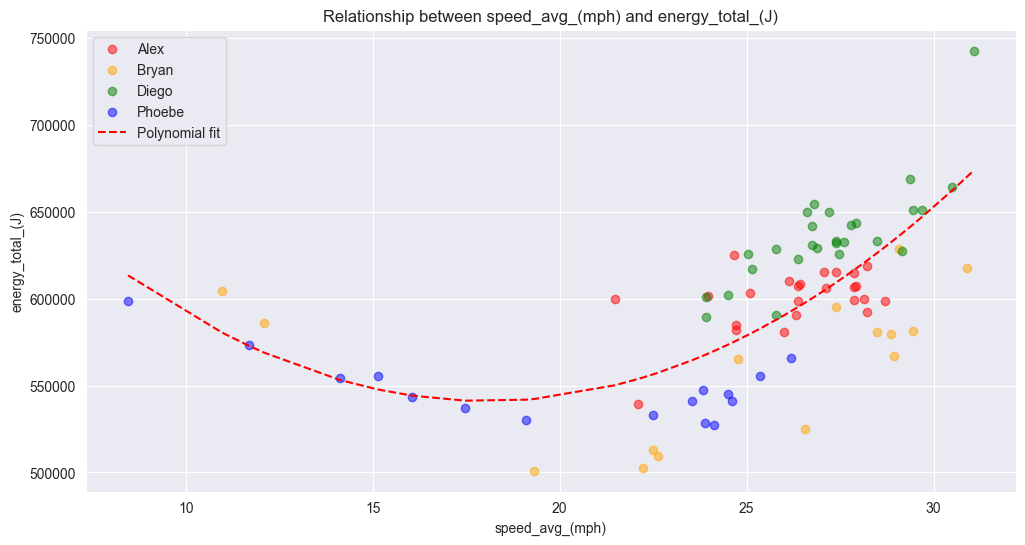

In [47]:
plot_relationship(filtered_df, "speed_avg_(mph)", poly_degree=2, color_by_driver=True)

Below we also have the speed variance per lap. There aren't any clear trends to correlate minimizing speed variance with maximizing efficiency

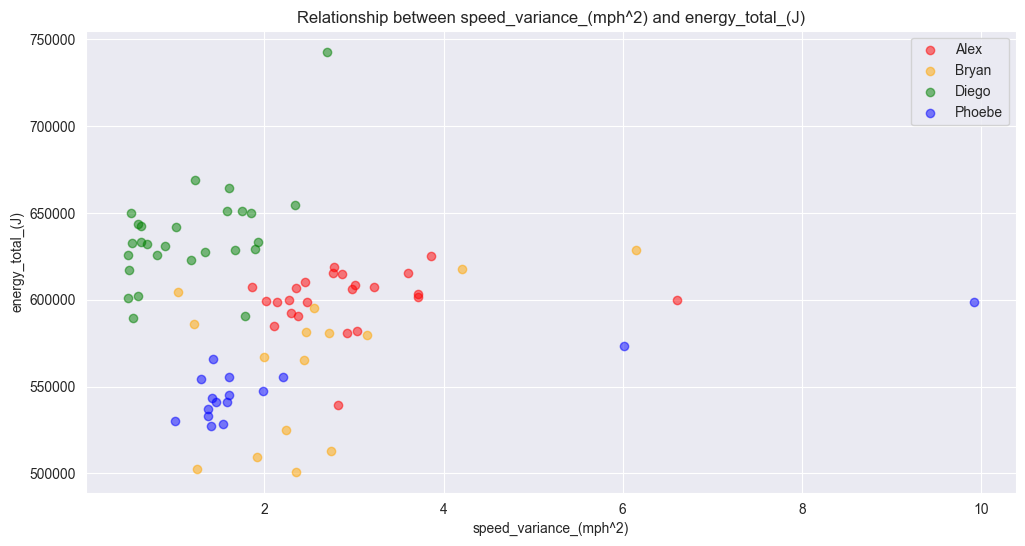

In [48]:
plot_relationship(filtered_df, "speed_variance_(mph^2)", show_fit=False, color_by_driver=True)

## Battery and Motor

### Average Battery Temperature

From the average batter temperature plots, we don't see much of a correlation between it and efficiency but we do get an idea of how the batter warms throughout a raceday. 

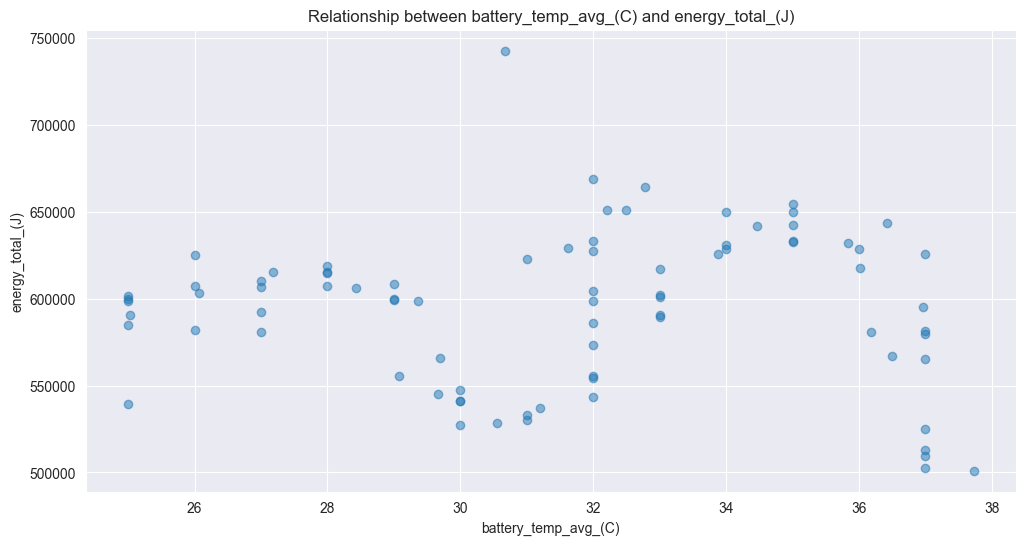

In [49]:
plot_relationship(filtered_df, "battery_temp_avg_(C)", show_fit=False)

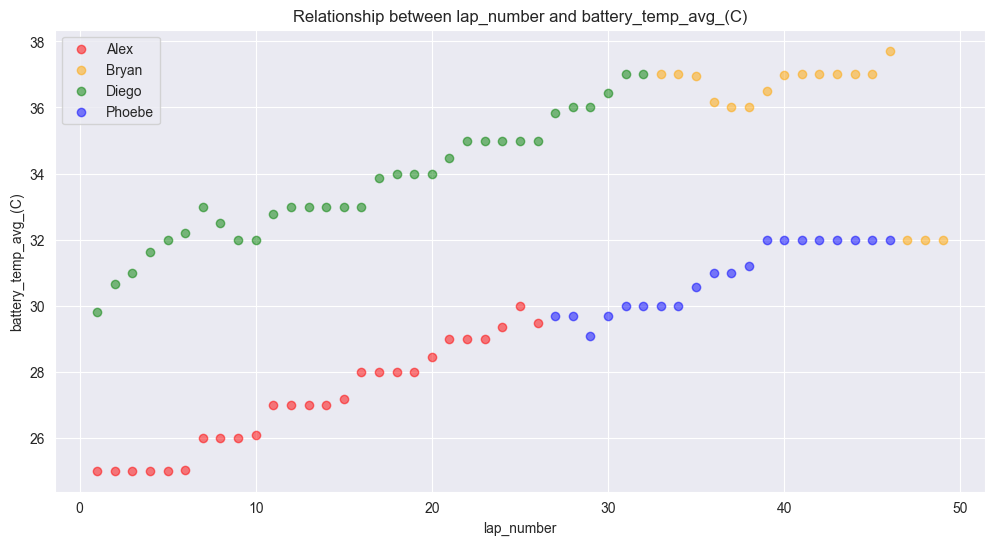

In [50]:
plot_relationship(df, target_col="battery_temp_avg_(C)", feature_col="lap_number", show_fit=False, color_by_driver=True)

Below are plots to show how our power/current draw from our motor and battery relates to our total energy usage.

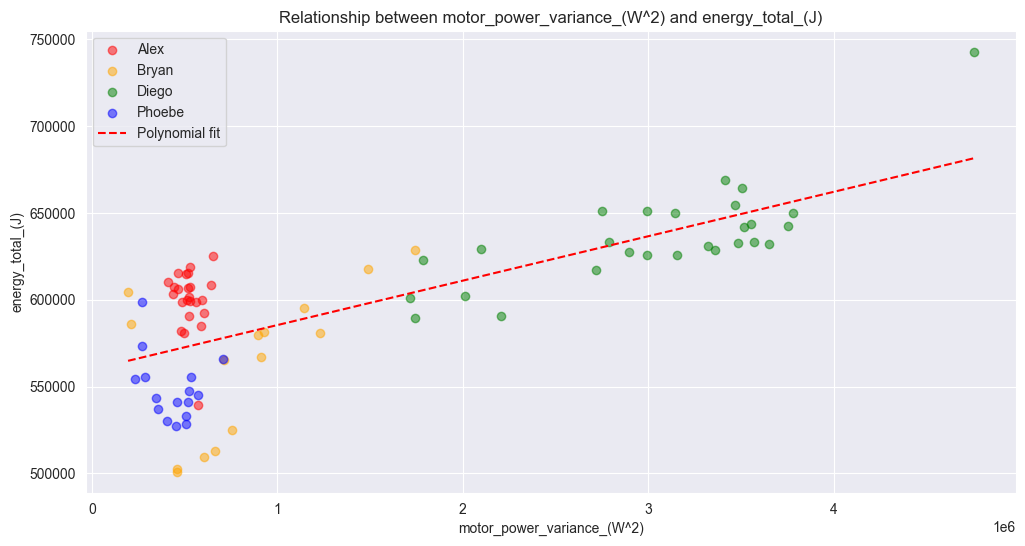

In [51]:
plot_relationship(filtered_df, feature_col="motor_power_variance_(W^2)", poly_degree=1, color_by_driver=True)

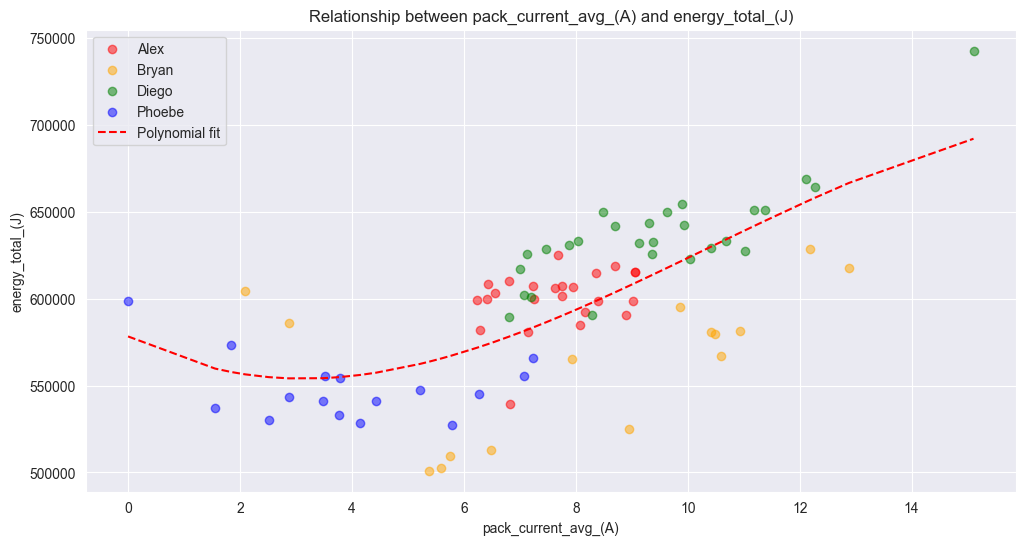

In [52]:
plot_relationship(filtered_df, "pack_current_avg_(A)", poly_degree=3, color_by_driver=True)

## Accelerator

Below are plots that relate how the driver steps on the accelerator with what happens in the rest of the car

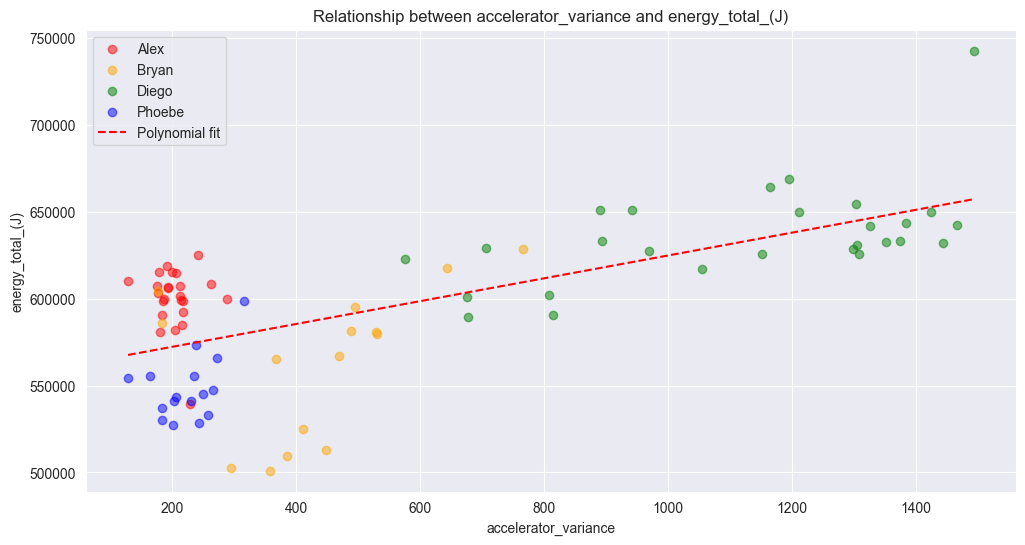

In [53]:
plot_relationship(filtered_df, feature_col="accelerator_variance", poly_degree=1, color_by_driver=True)

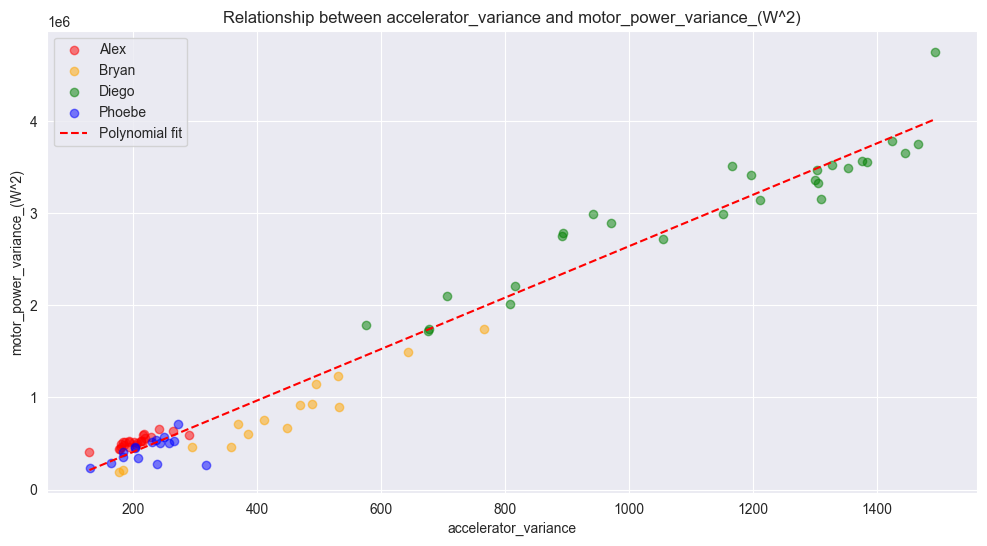

In [54]:
plot_relationship(filtered_df, feature_col="accelerator_variance", target_col="motor_power_variance_(W^2)", poly_degree=1, color_by_driver=True)

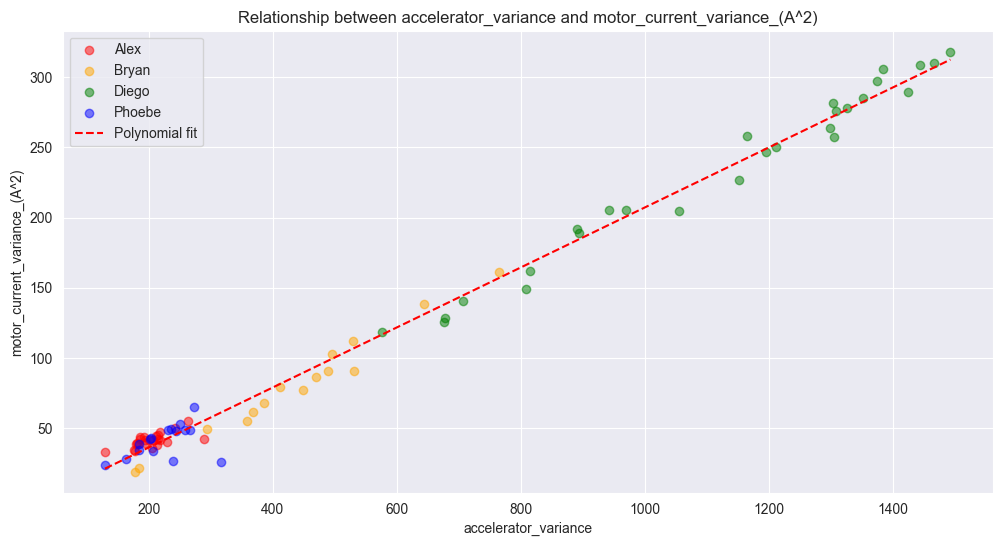

In [55]:
plot_relationship(filtered_df, feature_col="accelerator_variance", target_col="motor_current_variance_(A^2)", poly_degree=1, color_by_driver=True)

## Distance 
Below is a plot of the actual distance traveled by the car to complete a lap. It suggests a linear trend and intuitive trend that by travelling less of a distance would also reduce energy usage. This suggests that optimizing race lines can be a good strategy. We do see however that lower distance is strongly correlated with slower laps, which is likely because it is easier to take tight corners at lower speed. 

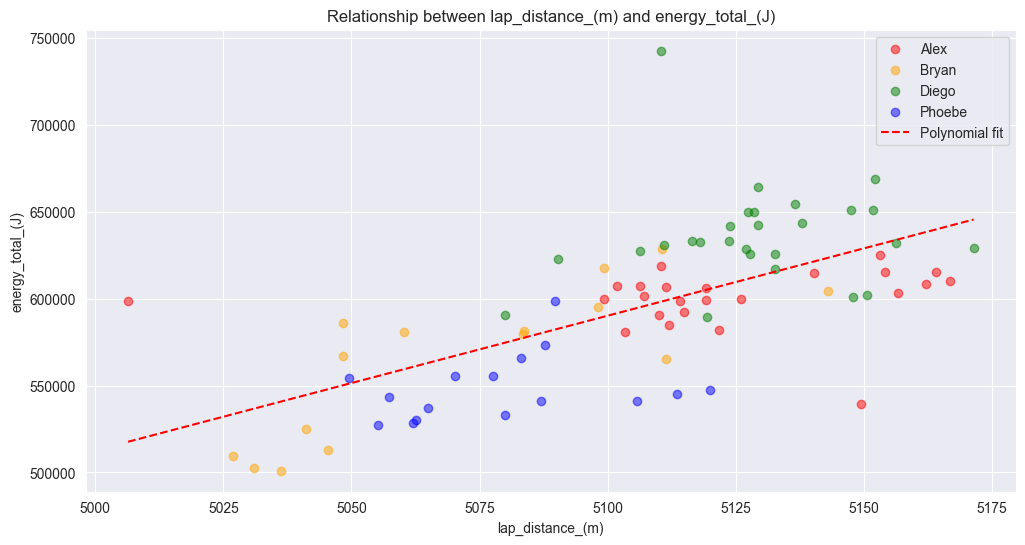

In [56]:
plot_relationship(filtered_df, feature_col="lap_distance_(m)", poly_degree=1, color_by_driver=True)

## Regen

From a regened energy plot alone, we don't see a direct trend with efficiency, but it seems that regen with a specific driver style may optimize efficiency.

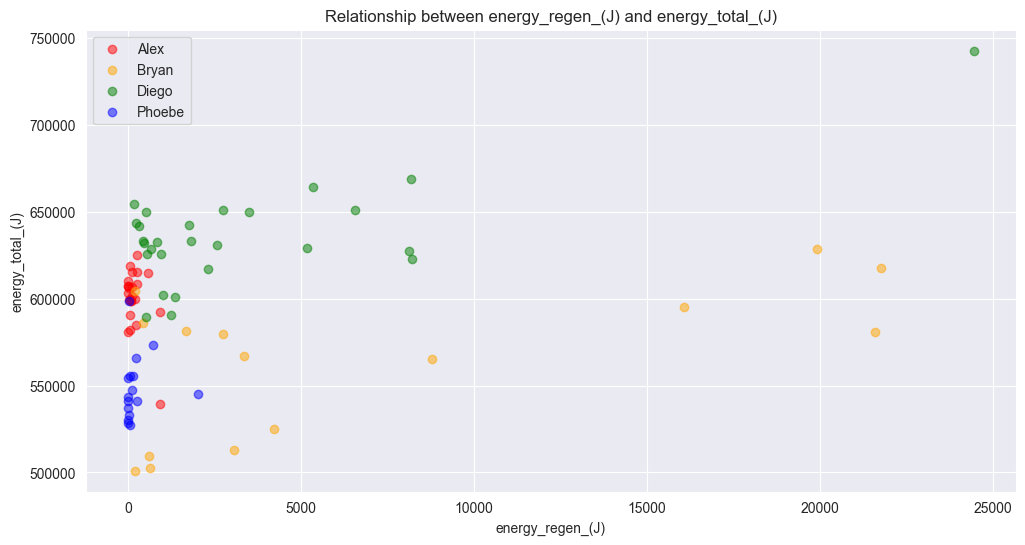

In [57]:
plot_relationship(filtered_df, "energy_regen_(J)", show_fit=False, color_by_driver=True)

## Wind

Below is a plot of wind speeds throughout the data and lap efficiencies. We hypothesized that high wind speeds would reduce efficiency by increasing aerodynamic drag (even though we might also benefit from tailwinds, the quadratic relationship makes higher wind speeds more punishing). However, the plot below does not show any clear relationship, at least not without decoupling efficiency from the many other more important factors.

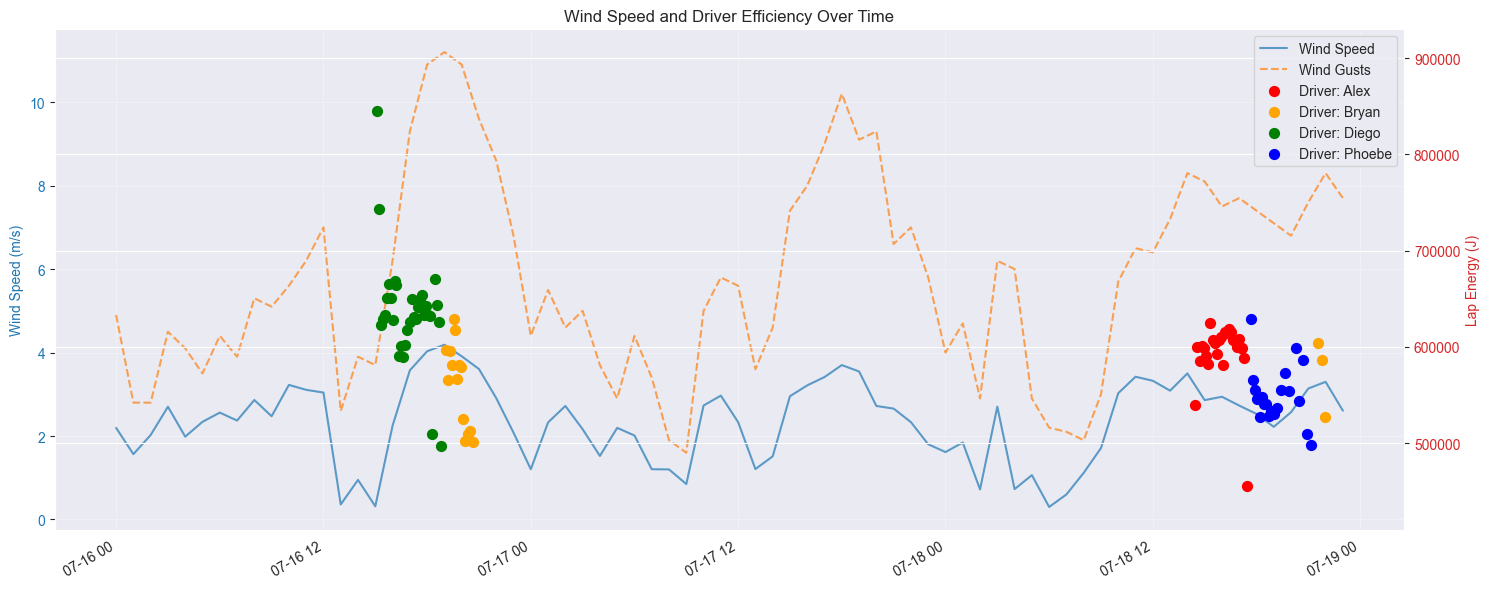

In [83]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

def fetch_wind_data(latitude, longitude, start_date, end_date):
    """
    Fetch hourly wind speed data from Open-Meteo API
    """
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ["wind_speed_10m", "wind_gusts_10m"],
        "wind_speed_unit": "ms"  # Using m/s for scientific analysis
    }
    
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]
    
    # Process hourly data
    hourly = response.Hourly()
    hourly_data = {
        "date": pd.date_range(
            start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
            end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
            freq = pd.Timedelta(seconds = hourly.Interval()),
            inclusive = "left"
        ),
        "wind_speed": hourly.Variables(0).ValuesAsNumpy(),
        "wind_gusts": hourly.Variables(1).ValuesAsNumpy(),
    }
    
    return pd.DataFrame(data = hourly_data)

def plot_wind_analysis(df, lap_end_times, lap_efficiencies, lap_drivers):
    """
    Create a combined plot of wind data and driver efficiencies using lap end times.
    """
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Plot wind data on primary y-axis (left)
    ax1.plot(df['date'], df['wind_speed'], label='Wind Speed', color='tab:blue', alpha=0.7)
    ax1.plot(df['date'], df['wind_gusts'], label='Wind Gusts', color='tab:orange', linestyle='--', alpha=0.7)
    ax1.set_ylabel('Wind Speed (m/s)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, alpha=0.3)

    # Set up secondary y-axis for lap efficiencies (right)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Lap Energy (J)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Set y-axis limits to fit lap_efficiencies data range
    if not lap_efficiencies.empty:
        ax2.set_ylim([lap_efficiencies.min() * 0.9, lap_efficiencies.max() * 1.1])

    # Plot each driver's efficiencies on secondary y-axis using lap end times
    for driver, color in driver_colours.items():
        mask = np.array(lap_drivers) == driver
        if np.any(mask):
            ax2.scatter(
                lap_end_times[mask],
                lap_efficiencies[mask],
                color=color,
                label=f"Driver: {driver}",
                alpha=1,
                s=50  # Increase marker size for visibility
            )
    
    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    # Format x-axis to show dates nicely
    plt.title('Wind Speed and Driver Efficiency Over Time')
    plt.xlabel('Lap End Time')
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()

# lat lon for center of track
latitude = 37.00272354871939
longitude = -86.36671627935802
start_date = "2024-07-16"  # FSGP Day 1
end_date = "2024-07-18"    # FSGP Day 3

wind_df = fetch_wind_data(latitude, longitude, start_date, end_date)
lap_end_timestamps = df["lap_end_time"]
lap_end_times = np.array(
    [datetime.datetime.strptime(ts, "%Y-%m-%d %H:%M:%S%z") for ts in lap_end_timestamps]

)
plot_wind_analysis(wind_df, lap_end_times, df["energy_total_(J)"], lap_drivers=df["driver"])    